## Preprocessing (pipeline)

In [31]:
import pandas as pd
import numpy as np

from sklearn import set_config
set_config(transform_output="pandas")

from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline, make_union
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from category_encoders import WOEEncoder
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

import shap
import seaborn as sns
import matplotlib.pyplot as plt

#### Load the data

In [32]:
data_train = pd.read_csv('../datasets/train.csv')
data_test = pd.read_csv('../datasets/test.csv')
pd.set_option('display.max_columns', None)

### Modeling
- we get (1) a labeled dataset (train.csv) and (2) an unlabeled dataset (test.csv)
- split train.csv into a train and test set
- that train set, u should split into train and validation sets (stratified CV split because imbalance)
- that test set has labels, so u can compare the predictions on X_test, y_test with the labels to evaluate performance of the different models **NOTE: to fit a model on the test set that is coming from train.csv, u need to pass the tuned values of the hyperparameters (tuned on the validation set)**
- choose the best performing model 
- then make predictions on test.csv (unlabeled) and export to a csv file which you upload to the website

#### Missing values

In [33]:
# For training data
missing_count = data_train.isnull().sum() 
missing_data = pd.DataFrame({'Column Name': missing_count.index, 'Missing Count': missing_count.values})
missing_data = missing_data.sort_values(by='Missing Count', ascending=False)
missing_data = missing_data[missing_data['Missing Count'] > 0]
missing_data

,Column Name,Missing Count
22,Dropped_calls_ratio,4
23,Usage_Band,4
25,call_cost_per_min,4


In [34]:
rows_with_missing_values_train = data_train[data_train.isnull().any(axis=1)]
print("Rows with Missing Values in training data:")
rows_with_missing_values_train

Rows with Missing Values in training data:


,Gender,Age,Connect_Date,L_O_S,Dropped_Calls,tariff,Handset,Peak_calls_Sum,Peak_mins_Sum,OffPeak_calls_Sum,OffPeak_mins_Sum,Weekend_calls_Sum,Weekend_mins_Sum,International_mins_Sum,Nat_call_cost_Sum,AvePeak,AveOffPeak,AveWeekend,National_calls,National mins,AveNational,All_calls_mins,Dropped_calls_ratio,Usage_Band,Mins_charge,call_cost_per_min,actual call cost,Total_call_cost,Total_Cost,Tariff_OK,average cost min,Peak ratio,OffPeak ratio,Weekend ratio,Nat-InterNat Ratio,high Dropped calls,No Usage,target,id
1736,F,48.0,26/07/98,26.966667,2.0,Play 100,BS110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,-600.0,NaN,0.0,0.0,59.94,OK,0.5,0.0,0.0,0.0,0.0,F,T,0,K244380
3237,F,34.0,22/03/97,43.333333,2.0,Play 100,BS110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,-600.0,NaN,0.0,0.0,59.94,OK,0.5,0.0,0.0,0.0,0.0,F,T,0,K244320
3836,M,21.0,03/01/96,58.133333,2.0,Play 100,CAS30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,-600.0,NaN,0.0,0.0,59.94,OK,0.5,0.0,0.0,0.0,0.0,F,T,1,K213590
4301,F,22.0,08/08/98,26.533333,5.0,Play 100,CAS30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,-600.0,NaN,0.0,0.0,59.94,OK,0.5,0.0,0.0,0.0,0.0,F,T,1,K212820


In [35]:
# For test data
missing_count = data_test.isnull().sum() 
missing_data = pd.DataFrame({'Column Name': missing_count.index, 'Missing Count': missing_count.values})
missing_data = missing_data.sort_values(by='Missing Count', ascending=False)
missing_data = missing_data[missing_data['Missing Count'] > 0]
missing_data

,Column Name,Missing Count
22,Dropped_calls_ratio,1
23,Usage_Band,1
25,call_cost_per_min,1


In [36]:
rows_with_missing_values_test = data_test[data_test.isnull().any(axis=1)]
print("\nRows with Missing Values in test data:")
rows_with_missing_values_test


Rows with Missing Values in test data:


,Gender,Age,Connect_Date,L_O_S,Dropped_Calls,tariff,Handset,Peak_calls_Sum,Peak_mins_Sum,OffPeak_calls_Sum,OffPeak_mins_Sum,Weekend_calls_Sum,Weekend_mins_Sum,International_mins_Sum,Nat_call_cost_Sum,AvePeak,AveOffPeak,AveWeekend,National_calls,National mins,AveNational,All_calls_mins,Dropped_calls_ratio,Usage_Band,Mins_charge,call_cost_per_min,actual call cost,Total_call_cost,Total_Cost,Tariff_OK,average cost min,Peak ratio,OffPeak ratio,Weekend ratio,Nat-InterNat Ratio,high Dropped calls,No Usage,id
1389,F,34.0,07/09/98,24.858347,2.0,Play 100,BS110,7.0,0.092169,2.0,12.29251,2.0,-3.12627,-3.215572,-5.011147,3.519628,2.912569,0.27729,-22.0,-2.090036,-0.10749,-20.274408,NaN,NaN,-599.241325,NaN,-3.291928,-2.74686,66.563274,OK,0.510543,0.001085,-0.017429,-0.003596,-0.004193,F,T,K689673


**we will impute this since it's so little rows**

In [37]:
target_column = 'target'

# Separate features and target variable
X_train = data_train.drop(target_column, axis=1)
y_train = data_train[target_column]

X_test = data_test

#### Split data into train and validation set 

target variable is binary and imbalanced (with the minority class having a frequency of 15%), so using a stratified splitting approach is recommended to ensure that both the training and validation sets have a similar distribution of the target variable.

In [38]:
stratified_splitter = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

for train_index, valid_index in stratified_splitter.split(X_train, y_train):
    X_train_split, X_valid_split = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_split, y_valid_split = y_train.iloc[train_index], y_train.iloc[valid_index]
    # Now you can use X_train_split, y_train_split for training and X_valid_split, y_valid_split for validation

In [39]:
total_train_samples = X_train_split.shape[0] + X_valid_split.shape[0]
train_distribution_percentage = (X_train_split.shape[0]/ total_train_samples) * 100
validation_distribution_percentage = (X_valid_split.shape[0] / total_train_samples) * 100

print(f"Training Set Distribution: {train_distribution_percentage:.2f}% ({X_train_split.shape[0]} rows)")
print(f"Validation Set Distribution: {validation_distribution_percentage:.2f}% ({X_valid_split.shape[0]} rows)")

Training Set Distribution: 75.00% (3783 rows)
Validation Set Distribution: 25.00% (1261 rows)


In [40]:
# Calculate the proportion of churners in y_train_split
proportion_churners_train = round(100*(y_train_split.sum() / len(y_train_split)), 2)

# Calculate the proportion of churners in y_valid_split
proportion_churners_valid = round(100*(y_valid_split.sum() / len(y_valid_split)),2)

print("Proportion of churners in y_train_split:", proportion_churners_train, "%")
print("Proportion of churners in y_valid_split:", proportion_churners_valid, "%")

Proportion of churners in y_train_split: 14.75 %
Proportion of churners in y_valid_split: 14.83 %


#### Pipeline

In [41]:
X_train_split.loc[:, 'Dropped_Calls'] = (X_train_split['Dropped_Calls'] > 11.5).astype(int)
X_valid_split.loc[:, 'Dropped_Calls'] = (X_valid_split['Dropped_Calls'] > 11.5).astype(int)
X_test.loc[:, 'Dropped_Calls'] = (X_test['Dropped_Calls'] > 11.5).astype(int)

In [42]:
X_train_split.loc[:, 'Tariff_OK'] = np.where(X_train_split['Tariff_OK'] == 'OK', 1, 0)
X_valid_split.loc[:, 'Tariff_OK'] = np.where(X_valid_split['Tariff_OK'] == 'OK', 1, 0)
X_test.loc[:, 'Tariff_OK'] = np.where(X_test['Tariff_OK'] == 'OK', 1, 0)

In [43]:
# Custom transformer to remove prefix from column names
class RemovePrefixTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, prefixes):
        self.prefixes = prefixes

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for prefix in self.prefixes:
            X.columns = [col.split(f'{prefix}__')[1] if f'{prefix}__' in col else col for col in X.columns]
        return X

you can handle them explicitly before preprocessing, for example, by replacing them with the most frequent category using fillna()

In [44]:
X_train_split = X_train_split.copy()
X_train_split['Usage_Band'] = X_train_split['Usage_Band'].fillna(X_train_split['Usage_Band'].mode()[0])
print(X_train_split['Usage_Band'].unique())

# Handle missing values in 'Dropped_calls_ratio' by filling with the median
X_train_split['Dropped_calls_ratio'] = X_train_split['Dropped_calls_ratio'].fillna(X_train_split['Dropped_calls_ratio'].median())

# Handle missing values in 'call_cost_per_min' by filling with the median
X_train_split['call_cost_per_min'] = X_train_split['call_cost_per_min'].fillna(X_train_split['call_cost_per_min'].median())

['Med' 'MedLow' 'MedHigh' 'Low' 'High']


In [45]:
X_valid_split = X_valid_split.copy()

# Handle missing values in 'Dropped_calls_ratio' by filling with the median
X_valid_split['Dropped_calls_ratio'] = X_valid_split['Dropped_calls_ratio'].fillna(X_train_split['Dropped_calls_ratio'].median())

# Handle missing values in 'call_cost_per_min' by filling with the median
X_valid_split['call_cost_per_min'] = X_valid_split['call_cost_per_min'].fillna(X_train_split['call_cost_per_min'].median())

# Handle missing values in 'Usage_Band' for X_validation_split
X_valid_split['Usage_Band'] = X_valid_split['Usage_Band'].fillna(X_train_split['Usage_Band'].mode()[0])

In [46]:
X_test = X_test.copy()
X_test['Usage_Band'] = X_test['Usage_Band'].fillna(X_train_split['Usage_Band'].mode()[0])
print(X_test['Usage_Band'].unique())

# Handle missing values in 'Dropped_calls_ratio' by filling with the median
X_test['Dropped_calls_ratio'] = X_test['Dropped_calls_ratio'].fillna(X_train_split['Dropped_calls_ratio'].median())

# Handle missing values in 'call_cost_per_min' by filling with the median
X_test['call_cost_per_min'] = X_test['call_cost_per_min'].fillna(X_train_split['call_cost_per_min'].median())

['MedHigh' 'Med' 'High' 'MedLow' 'Low']


In [47]:
# Define columns to drop
columns_to_drop = ['id', 'Connect_Date', 'Dropped_Calls']

# Define columns for different pre-processing methods
one_hot_encode_columns = ['Gender', 'high Dropped calls', 'No Usage']
woe_encode_columns = ['tariff', 'Handset', 'Usage_Band'] 
PCA_columns = ['Peak_calls_Sum', 'Peak_mins_Sum', 'OffPeak_calls_Sum', 'OffPeak_mins_Sum',
               'Weekend_calls_Sum', 'Weekend_mins_Sum', 'International_mins_Sum', 'Nat_call_cost_Sum', 
               'National_calls', 'National mins', 'National mins', 'All_calls_mins', 'Dropped_calls_ratio', 
               'Mins_charge', 'call_cost_per_min', 'actual call cost', 'Total_call_cost', 'Total_Cost', 
               'Peak ratio', 'OffPeak ratio', 'Weekend ratio', 'Nat-InterNat Ratio'] #'average cost min'
standard_columns = ['Age', 'L_O_S']
robust_columns = ['AvePeak', 'AveOffPeak', 'AveWeekend', 'AveNational']

# Define the PCA pipeline
pca_pipeline = Pipeline([
    ('standardscaler', StandardScaler()), # Standardize the data (needed for PCA)
    ('pca', PCA(n_components=0.78))       # Apply PCA to retain 80% of the variance
])

# Modify the preprocessing pipeline to apply PCA only on PCA columns
preprocessor = ColumnTransformer(
    transformers=[
        ('drop_columns', 'drop', columns_to_drop),
        ('one_hot_encode', OneHotEncoder(drop='first', sparse_output=False), one_hot_encode_columns),
        ('WOE_encode', WOEEncoder(), woe_encode_columns),
        ('pca', pca_pipeline, PCA_columns), 
        ('standardize1', StandardScaler(), standard_columns),
        ('standardize2', RobustScaler(), robust_columns)
    ],
    remainder='passthrough'  # Keep the remaining columns as they are
)

# Build the preprocessing pipeline
preprocessing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('remove_prefix', RemovePrefixTransformer(prefixes=['one_hot_encode', 'WOE_encode', 'pca', 
                                                        'standardize1', 'standardize2', 'remainder']))
])


## RANDOM FOREST
rf_classifier=RandomForestClassifier(random_state=42, class_weight='balanced')

# Define the final pipeline with PCA
lgb_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing_pipeline),
    ('model', rf_classifier)
])

## LIGHT GBM
positive_fraction = y_train_split.sum() / len(y_train_split)
lgb_classifier = lgb.LGBMClassifier(scale_pos_weight= 1 / positive_fraction)

# Define the final pipeline with PCA
lgb_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing_pipeline),
    ('model', lgb_classifier)
])

## XGBOOST
positive_fraction = y_train_split.sum() / len(y_train_split)
xgb_classifier= xgb.XGBClassifier(scale_pos_weight = 1 / positive_fraction, random_state=42)

# Define the final pipeline with PCA
lgb_pipeline_with_pca = Pipeline(steps=[
    ('preprocessing', preprocessing_pipeline),
    ('model', xgb_classifier)
])

In [48]:
def calculate_profit_metric(y_true, y_test_proba, dataset=X_train_split, top_k=20):
    # Reset indices of the dataset DataFrame
    dataset.reset_index(drop=True, inplace=True)
    
    # Convert y_probabilities to a DataFrame and then reset indices
    #proba_df = pd.DataFrame(proba, columns=['Prob_0', 'Prob_1'])
    proba_df = pd.DataFrame(y_test_proba, columns=['Prob_1'])
    proba_df.reset_index(drop=True, inplace=True)

    y_true.reset_index(drop=True, inplace=True)

    # Now concatenate the DataFrames
    profit_df = pd.concat([dataset[['average cost min']], proba_df, y_true], axis=1)

    # Sort concatenated_df by PROB_1 column in descending order
    profit_df_sorted = profit_df.sort_values(by='Prob_1', ascending=False)

    # Filter the top 20 rows
    top_k_rows = profit_df_sorted.head(top_k)

    # Filter the top 20 rows where target == 1 (actual churner) and sum the 'average cost min' values
    profit_at_top_k = top_k_rows[(top_k_rows[y_true.name] == 1) & (top_k_rows['Prob_1'] > 0.5)]['average cost min'].sum() 
    
    return profit_at_top_k

#response_method='predict_proba', 
profit_scorer = make_scorer(calculate_profit_metric, needs_proba=True, greater_is_better=True)

In [49]:
from sklearn.metrics import precision_score

def precision_at_k(y_true, y_test_proba):
    threshold = np.sort(y_test_proba)[::-1][int(0.0066*len(y_test_proba))] #0.00529
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_test_proba])
    return precision_score(y_true, y_pred)

precision_at_k_scorer = make_scorer(precision_at_k, needs_proba=True)

Precision: Precision measures the proportion of true positive predictions among all positive predictions made by the model. It focuses on minimizing false positives, which is useful when the cost of incorrectly predicting a positive (churn) is high. Optimizing for precision ensures that when the model predicts churn, it's highly confident that the customer will churn. This can be important in scenarios where resources for intervention (such as retention offers) are limited, and you want to ensure that they are allocated effectively. --> try to maximize precision?

In [50]:
X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train_split, y_train_split)
X_train_preprocessed

,Gender_M,high Dropped calls_T,No Usage_T,tariff,Handset,Usage_Band,pca0,pca1,pca2,pca3,Age,L_O_S,AvePeak,AveOffPeak,AveWeekend,AveNational,Tariff_OK,average cost min
0,0.0,0.0,0.0,0.421050,-0.951537,-0.271153,-2.568681,2.103107,-0.970825,0.336637,1.479855,-0.315520,-0.108087,-0.148181,1.265743,-0.219327,1,0.150531
1,1.0,0.0,0.0,-0.173919,2.982628,-0.271153,0.727921,-1.376481,-0.489993,1.714494,-0.491319,0.917762,0.507529,-0.330827,1.851660,0.337205,1,0.188988
3,0.0,0.0,0.0,-0.016968,0.007327,0.756511,-2.222597,-1.437766,-2.204695,-0.437399,2.189477,-0.443591,0.220543,-0.024856,-0.806401,0.195994,1,0.221467
4,0.0,0.0,0.0,-0.485256,-2.908287,-0.271153,-2.209708,3.358562,-1.820766,-0.961110,-0.491319,-0.868125,4.817387,-0.257835,-0.120450,-0.081423,1,0.107509
5,1.0,0.0,0.0,-0.173919,-0.135439,-0.271153,-1.667525,-0.510305,-0.414703,-1.002194,-0.333625,0.374644,-0.115337,44.515591,-0.283772,0.520425,1,0.162952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,0.0,0.0,0.0,-0.173919,0.007327,-0.271153,-0.614652,-2.741799,0.595936,0.094180,-0.727860,-1.264198,6.227392,0.653429,-0.224919,4.237628,1,0.177791
5039,0.0,0.0,0.0,0.033322,2.982628,0.008762,3.607626,1.771087,0.888979,-0.774427,-1.200941,0.270289,1.214787,0.090600,-0.206194,0.878667,1,0.130433
5040,0.0,0.0,0.0,-0.173919,2.975147,-0.271153,-1.105980,0.270728,-0.796901,0.881906,-0.175931,1.105126,0.026466,-0.132774,-0.208792,-0.115895,1,0.189112
5042,1.0,0.0,0.0,0.421050,-0.135439,0.756511,-3.786768,0.269913,-1.791040,0.547872,1.164467,-0.125784,-0.336080,1.193783,-0.206194,0.154632,1,0.205957


In [60]:
# Convert "Tariff_OK" column to integer type
X_train_preprocessed['Tariff_OK'] = X_train_preprocessed['Tariff_OK'].astype(int)

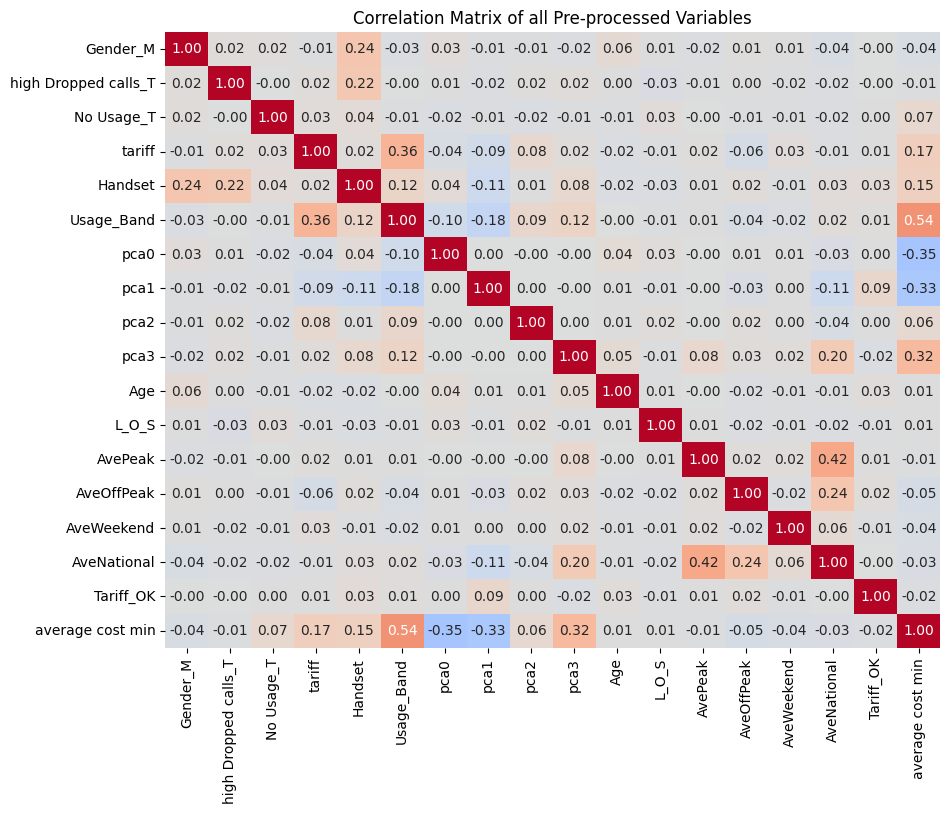

In [51]:
# Recalculate correlation matrix
correlation_matrix = X_train_preprocessed.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=False, center=0)
plt.title('Correlation Matrix of all Pre-processed Variables')
plt.show()

#### RF

In [52]:
rf_param_dist = {
    'n_estimators': randint(130, 150),  
    'max_depth': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 4, 6, 8, 10],  
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [1, 2, 4, 6]
} 
rf_grid_search = RandomizedSearchCV(rf_classifier, rf_param_dist, scoring={'profit': profit_scorer, 'auc': 'roc_auc'}, 
                                     refit='profit', verbose=0, cv=5, n_jobs=-1, n_iter=100)

# Fit the GridSearchCV on training data 
rf_grid_search.fit(X_train_preprocessed, y_train_split)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5],
                                        'min_samples_leaf': [1, 2, 4, 6],
                                        'min_samples_split': [2, 4, 6, 8, 10],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000278B4BDB5E0>},
                   refit='profit',
                   scoring={'auc': 'roc_auc',
                            'profit': make_scorer(calculate_profit_metric, needs_proba=True)})

In [53]:
best_rf_model = rf_grid_search.best_estimator_ #has the optimal hyperparameters
best_rf_model 

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=1, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=130, random_state=42)

In [54]:
print("Best Score:", rf_grid_search.best_score_)
print("Best Parameters:", rf_grid_search.best_params_)

Best Score: 2.8849064
Best Parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 130}


In [55]:
# Fit the best model on the training data
best_rf_model.fit(X_train_preprocessed, y_train_split) 

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=1, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=130, random_state=42)

In [56]:
# Apply preprocessing pipeline to the validation set IPV FIT_TRANSFORM GWN TRANSFORM BC INFO VAN TRAINING SET
X_valid_preprocessed = preprocessing_pipeline.transform(X_valid_split)

pred = best_rf_model.predict(X_valid_preprocessed)

# Evaluate on the validation set 
y_valid_probabilities_rf = best_rf_model.predict_proba(X_valid_preprocessed)

In [57]:
# Evaluate on the validation set 
auc_score_rf = roc_auc_score(y_valid_split, y_valid_probabilities_rf[:, 1])

profit_metric = calculate_profit_metric(y_valid_split, y_valid_probabilities_rf[:, 1], X_valid_split, top_k=20)

print(f'AUC on Validation Set: {auc_score_rf}')
print(f'Profit @ Top-20 on Validation Set: {profit_metric}')

AUC on Validation Set: 0.8930207430864676
Profit @ Top-20 on Validation Set: 4.846248


In [58]:
# Apply preprocessing pipeline to the validation set
X_test_preprocessed = preprocessing_pipeline.transform(X_test)

# Evaluate on the test set for LightGBM
y_test_probabilities_rf = best_rf_model.predict_proba(X_test_preprocessed)
y_test_probabilities_rf = pd.DataFrame(y_test_probabilities_rf, columns=['PROB_0', 'PROB_1'])
y_test_probabilities_rf_with_id = pd.concat([data_test['id'], y_test_probabilities_rf], axis=1)

# Extract only the probability to churn
result_RF = y_test_probabilities_rf_with_id.iloc[:, [0, 2]]
result_RF

# Export
result_RF.to_csv('result_RF.csv', header=False, index=False)

#### LGB

In [61]:
lgb_param_dist = {
    'n_estimators': randint(130, 150), 
    'max_depth': [1, 2, 3, 5],
    'learning_rate': uniform(0.01, 0.05)  
} 
lgb_grid_search = RandomizedSearchCV(lgb_classifier, lgb_param_dist, scoring={'profit': profit_scorer, 'auc': 'roc_auc'}, 
                                     refit='profit', verbose=0, cv=5, n_jobs=-1, n_iter=100)

# Fit the GridSearchCV on training data 
lgb_grid_search.fit(X_train_preprocessed, y_train_split)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 558, number of negative: 3225
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2645
[LightGBM] [Info] Number of data points in the train set: 3783, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.147502 -> initscore=-1.754329
[LightGBM] [Info] Start training from score -1.754329


RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(scale_pos_weight=6.779569892473118),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000278B635E380>,
                                        'max_depth': [1, 2, 3, 5],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000278B4BDA350>},
                   refit='profit',
                   scoring={'auc': 'roc_auc',
                            'profit': make_scorer(calculate_profit_metric, needs_proba=True)})

In [62]:
best_lgb_model = lgb_grid_search.best_estimator_ #has the optimal hyperparameters
best_lgb_model 

LGBMClassifier(learning_rate=0.029076987200504806, max_depth=1,
               n_estimators=143, scale_pos_weight=6.779569892473118)

In [63]:
print("Best Score:", lgb_grid_search.best_score_)
print("Best Parameters:", lgb_grid_search.best_params_)

Best Score: 3.018404
Best Parameters: {'learning_rate': 0.029076987200504806, 'max_depth': 1, 'n_estimators': 143}


In [64]:
# Fit the best model on the training data
best_lgb_model.fit(X_train_preprocessed, y_train_split) 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 558, number of negative: 3225
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2645
[LightGBM] [Info] Number of data points in the train set: 3783, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.147502 -> initscore=-1.754329
[LightGBM] [Info] Start training from score -1.754329


LGBMClassifier(learning_rate=0.029076987200504806, max_depth=1,
               n_estimators=143, scale_pos_weight=6.779569892473118)

In [65]:
# Apply preprocessing pipeline to the validation set IPV FIT_TRANSFORM GWN TRANSFORM BC INFO VAN TRAINING SET
X_valid_preprocessed = preprocessing_pipeline.transform(X_valid_split)
X_valid_preprocessed['Tariff_OK'] = X_valid_preprocessed['Tariff_OK'].astype(int)

pred = best_lgb_model.predict(X_valid_preprocessed)

# Evaluate on the validation set 
y_valid_probabilities_lgb = best_lgb_model.predict_proba(X_valid_preprocessed)

In [66]:
# Evaluate on the validation set 
auc_score_lgb = roc_auc_score(y_valid_split, y_valid_probabilities_lgb[:, 1])

profit_metric = calculate_profit_metric(y_valid_split, y_valid_probabilities_lgb[:, 1], X_valid_split, top_k=20)

print(f'AUC on Validation Set: {auc_score_lgb}')
print(f'Profit @ Top-20 on Validation Set: {profit_metric}')

AUC on Validation Set: 0.9162260130055069
Profit @ Top-20 on Validation Set: 3.024179


In [67]:
# Apply preprocessing pipeline to the validation set
X_test_preprocessed = preprocessing_pipeline.transform(X_test)
X_test_preprocessed['Tariff_OK'] = X_test_preprocessed['Tariff_OK'].astype(int)

# Evaluate on the test set for LightGBM
y_test_probabilities_lgb = best_lgb_model.predict_proba(X_test_preprocessed)
y_test_probabilities_lgb = pd.DataFrame(y_test_probabilities_lgb, columns=['PROB_0', 'PROB_1'])
y_test_probabilities_lgb_with_id = pd.concat([data_test['id'], y_test_probabilities_lgb], axis=1)

# Extract only the probability to churn
result_lgb = y_test_probabilities_lgb_with_id.iloc[:, [0, 2]]
result_lgb

# Export
result_lgb.to_csv('result_LGB.csv', header=False, index=False)

#### XGB

In [68]:
xgb_param_dist = {
    'n_estimators': randint(130, 150),  # Adjust bounds based on your preference
    'max_depth': [1, 2, 3, 5, 6],
    'learning_rate': uniform(0.01, 0.05) #0.15
} 
xgb_grid_search = RandomizedSearchCV(xgb_classifier, xgb_param_dist, scoring={'profit': profit_scorer, 'auc': 'roc_auc'}, 
                                     refit='profit', verbose=0, cv=5, n_jobs=-1, n_iter=100)

# Fit the GridSearchCV on training data 
xgb_grid_search.fit(X_train_preprocessed, y_train_split)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           predictor=None, random_state=42, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000278B635D8D0>,
                                        'max_depth': [1, 2, 3, 5, 6],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000278B4671420>},
                   refit='profit',
                   scoring={'auc': 'roc_auc',
                            'profit': make_scorer(calculate_profit_metric, needs_proba=True)})

In [69]:
best_xgb_model = xgb_grid_search.best_estimator_ #has the optimal hyperparameters
best_xgb_model 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05813391500448283,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=134, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [70]:
print("Best Score:", xgb_grid_search.best_score_)
print("Best Parameters:", xgb_grid_search.best_params_)

Best Score: 2.9363912
Best Parameters: {'learning_rate': 0.05813391500448283, 'max_depth': 1, 'n_estimators': 134}


In [71]:
# Fit the best model on the training data
best_xgb_model.fit(X_train_preprocessed, y_train_split) 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05813391500448283,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=134, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [72]:
# Apply preprocessing pipeline to the validation set IPV FIT_TRANSFORM GWN TRANSFORM BC INFO VAN TRAINING SET
X_valid_preprocessed = preprocessing_pipeline.transform(X_valid_split)
X_valid_preprocessed['Tariff_OK'] = X_valid_preprocessed['Tariff_OK'].astype(int)

pred = best_xgb_model.predict(X_valid_preprocessed)

# Evaluate on the validation set 
y_valid_probabilities_xgb = best_xgb_model.predict_proba(X_valid_preprocessed)

In [73]:
# Evaluate on the validation set 
auc_score_xgb = roc_auc_score(y_valid_split, y_valid_probabilities_xgb[:, 1])

profit_metric = calculate_profit_metric(y_valid_split, y_valid_probabilities_xgb[:, 1], X_valid_split, top_k=20)

print(f'AUC on Validation Set: {auc_score_xgb}')
print(f'Profit @ Top-20 on Validation Set: {profit_metric}')

AUC on Validation Set: 0.9315766936535914
Profit @ Top-20 on Validation Set: 3.843702


In [74]:
# Apply preprocessing pipeline to the validation set
X_test_preprocessed = preprocessing_pipeline.transform(X_test)
X_test_preprocessed['Tariff_OK'] = X_test_preprocessed['Tariff_OK'].astype(int)

# Evaluate on the test set for LightGBM
y_test_probabilities_xgb = best_xgb_model.predict_proba(X_test_preprocessed)
y_test_probabilities_xgb = pd.DataFrame(y_test_probabilities_xgb, columns=['PROB_0', 'PROB_1'])
y_test_probabilities_xgb_with_id = pd.concat([data_test['id'], y_test_probabilities_xgb], axis=1)

# Extract only the probability to churn
result_xgb = y_test_probabilities_xgb_with_id.iloc[:, [0, 2]]
result_xgb

# Export
result_xgb.to_csv('result_XGB.csv', header=False, index=False)